In [ ]:
!pip install imbalanced-learn scikit-learn
!pip install statsmodels


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
# importing libraries here to better keep track of them

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report

In [49]:
# Reading csv files into memory

injury_history_raw = pd.read_csv("data/injury_history(injury_history).csv", sep = ",", encoding = 'ISO-8859-1')
muscle_imbalance_raw = pd.read_csv("data/injury_history(muscle_imbalance_data).csv", sep = ",", encoding = 'ISO-8859-1')
player_sessions_raw = pd.read_csv("data/injury_history(player_sessions).csv", sep = ",", encoding = 'ISO-8859-1')

In [50]:
injury_history_raw['Injury Date'] = pd.to_datetime(injury_history_raw['Injury Date'], errors = 'coerce')
injury_history_raw['Month'] = injury_history_raw['Injury Date'].dt.month
injury_history_raw['Year'] = injury_history_raw['Injury Date'].dt.year

player_sessions_raw['Month'] = pd.to_datetime(player_sessions_raw['Session_Date']).dt.month
player_sessions_raw['Year'] = pd.to_datetime(player_sessions_raw['Session_Date']).dt.year

muscle_imbalance_raw['Month'] = pd.to_datetime(muscle_imbalance_raw['Date Recorded']).dt.month
muscle_imbalance_raw['Year'] = pd.to_datetime(muscle_imbalance_raw['Date Recorded']).dt.year

In [51]:
injury_history_raw[['Player.ID', 'Name', 'Injury Date', 'Month','Year']].value_counts()

Player.ID  Name              Injury Date  Month  Year
101        Jordan Matthews   2023-07-22   7      2023    1
                             2023-10-25   10     2023    1
                             2023-12-05   12     2023    1
103        Malik Robinson    2023-02-14   2      2023    1
                             2023-06-28   6      2023    1
                             2023-09-27   9      2023    1
105        Noah Bradley      2023-01-13   1      2023    1
                             2023-09-20   9      2023    1
                             2023-12-19   12     2023    1
106        Lennon Van        2024-01-01   1      2024    1
107        Cameron Howard    2023-12-21   12     2023    1
109        Miles Richardson  2023-07-05   7      2023    1
110        Kyle Saunders     2023-10-09   10     2023    1
112        Anthony Lopez     2023-01-26   1      2023    1
                             2023-07-15   7      2023    1
                             2023-11-18   11     2023    1
11

In [52]:
injury_history_raw.sort_values(['Player.ID', 'Injury Date', 'Month', 'Year'], inplace = True)
injury_history_raw['injury_number'] = injury_history_raw.groupby('Player.ID').cumcount() + 1
injury_history_raw[['Player.ID', 'Name', 'Injury Date', 'Month','Year', 'injury_number']].value_counts()

Player.ID  Name              Injury Date  Month  Year  injury_number
101        Jordan Matthews   2023-07-22   7      2023  1                1
                             2023-10-25   10     2023  2                1
                             2023-12-05   12     2023  3                1
103        Malik Robinson    2023-02-14   2      2023  1                1
                             2023-06-28   6      2023  2                1
                             2023-09-27   9      2023  3                1
105        Noah Bradley      2023-01-13   1      2023  1                1
                             2023-09-20   9      2023  2                1
                             2023-12-19   12     2023  3                1
106        Lennon Van        2024-01-01   1      2024  1                1
107        Cameron Howard    2023-12-21   12     2023  1                1
109        Miles Richardson  2023-07-05   7      2023  1                1
110        Kyle Saunders     2023-10-09   1

In [53]:
print(f"Raw Injury Data: \n {injury_history_raw.head()} \n")
print(f"Raw Muscle Imbalance Data: \n {muscle_imbalance_raw.head()} \n")
print(f"Raw Player Session Data: \n {player_sessions_raw.head()} \n")

Raw Injury Data: 
    Player.ID             Name  Group.Id    Injury Type   Body Part   Side  \
2        101  Jordan Matthews       201     Tendonitis    Shoulder  Right   
1        101  Jordan Matthews       201     Tendonitis       Wrist   Left   
0        101  Jordan Matthews       201  Muscle Strain  Quadriceps  Right   
4        103   Malik Robinson       203       Fracture       Wrist   Left   
3        103   Malik Robinson       203         Strain       Groin  Right   

  Injury Date Severity  Recovery Time (days)  \
2  2023-07-22      NaN                    12   
1  2023-10-25      NaN                    11   
0  2023-12-05  Grade 2                    51   
4  2023-02-14      NaN                    68   
3  2023-06-28  Grade 1                    20   

                                    Additional Notes  Month  Year  \
2  Rotator cuff tendonitis due to overuse. Anti-i...      7  2023   
1  De Quervain's tenosynovitis. Swelling and pain...     10  2023   
0  Grade 2 quadriceps 

In [54]:
print(f'Columns present in injury data: \n {injury_history_raw.columns} \n')
print(f'Columns present in muscle imbalance data: \n {muscle_imbalance_raw.columns} \n')
print(f'Columns present in player session data: \n {player_sessions_raw.columns} \n')

Columns present in injury data: 
 Index(['Player.ID', 'Name', 'Group.Id', 'Injury Type', 'Body Part', 'Side',
       'Injury Date', 'Severity', 'Recovery Time (days)', 'Additional Notes',
       'Month', 'Year', 'injury_number'],
      dtype='object') 

Columns present in muscle imbalance data: 
 Index(['Player.ID', 'Session ID', 'Player Name', 'Date Recorded',
       'Hamstring To Quad Ratio', 'Quad Imbalance Percent',
       'HamstringImbalance Percent', 'Calf Imbalance Percent',
       'Groin Imbalance Percent', 'Month', 'Year'],
      dtype='object') 

Columns present in player session data: 
 Index(['Name', 'Player.ID', 'Group.Id', 'Group.name', 'League.ID',
       'Session.ID', 'Session_Date', 'Position', 'Distance..mi.',
       'Distance...min..mi.', 'Duration..s.', 'Steps', 'Speed....of.max......',
       'Speed..max....mph.', 'Speed..?ò...mph.', 'Time..s.',
       'Accumulated.Acceleration.Load', 'Anaerobic.Activity..distance...mi.',
       'Jump.Load..J.', 'Heart.Rate..?ò...b

## Player Session Data column research

#### TRIMP - A way to measure Training Impulse (Aerobic Training Load). It is a product of Training volume (minutes) and Training intensity (beats per minutes). 

TRIMP = Training VOlume * Training Intensity. For example if a workout is 50 minutes and the average heart rate (bpm) is 140 bpm, TRIMP score is calculated out to 7000. TRIMP is affected by a number of factors but we can look for correlation on a correlation matrix as well. 
    - Physical Settings
    - Resting and Maximal Heart Rate
    - Gender (since its mbb there's not going to be any variance with this feature)

TRIMP can be used to compare sessions of different lengths, or to compare high-intensity sessions with longer game data. For example if a session with TRIMP score of 108 might be considered moderate, the TRIMP/min score could indicate an intense session if Training Volume is lower. Training Stress Score (TSS) is a proprietary variant based on a score of 100 for a 1-hour maximum sustained effort. 
Positive correlation between Heart Rate and Effort

---

In [55]:
print(f'Size of injury history data: \n {injury_history_raw.shape}\n')
print(f'Size of muscle imbalance data: \n {muscle_imbalance_raw.shape}\n')
print(f'Size of player session data: \n {player_sessions_raw.shape}\n')

Size of injury history data: 
 (21, 13)

Size of muscle imbalance data: 
 (182, 11)

Size of player session data: 
 (2604, 32)



## Null Values

In [56]:
print(f'Null Values in injury history data: \n {injury_history_raw.isnull().sum()}')
print(f'Null Values in muscle imbalance data: \n {muscle_imbalance_raw.isnull().sum()}')
print(f'Null Values in player session data: \n {player_sessions_raw.isnull().sum()}')

Null Values in injury history data: 
 Player.ID                0
Name                     0
Group.Id                 0
Injury Type              0
Body Part                0
Side                     5
Injury Date              0
Severity                10
Recovery Time (days)     0
Additional Notes         0
Month                    0
Year                     0
injury_number            0
dtype: int64
Null Values in muscle imbalance data: 
 Player.ID                     0
Session ID                    0
Player Name                   0
Date Recorded                 0
Hamstring To Quad Ratio       0
Quad Imbalance Percent        0
HamstringImbalance Percent    0
Calf Imbalance Percent        0
Groin Imbalance Percent       0
Month                         0
Year                          0
dtype: int64
Null Values in player session data: 
 Name                                  0
Player.ID                             0
Group.Id                              0
Group.name                         

Okay so with null values, injury history data is the only dataset with null values. There are 2 columns with null values with a total of 15 null values. Less than 10% of the data. We should delete the data since we are working with health data instead of imputing the values. I think it will introduce bias through assumption. Our train test split is going to be pretty weak since we only will have 167 instances. 

In [57]:
injury_history_raw.sort_index(inplace = True)

In [58]:
injury_history_raw

,Player.ID,Name,Group.Id,Injury Type,Body Part,Side,Injury Date,Severity,Recovery Time (days),Additional Notes,Month,Year,injury_number
0,101,Jordan Matthews,201,Muscle Strain,Quadriceps,Right,2023-12-05,Grade 2,51,Grade 2 quadriceps strain with partial tearing...,12,2023,3
1,101,Jordan Matthews,201,Tendonitis,Wrist,Left,2023-10-25,NaN,11,De Quervain's tenosynovitis. Swelling and pain...,10,2023,2
2,101,Jordan Matthews,201,Tendonitis,Shoulder,Right,2023-07-22,NaN,12,Rotator cuff tendonitis due to overuse. Anti-i...,7,2023,1
3,103,Malik Robinson,203,Strain,Groin,Right,2023-06-28,Grade 1,20,"Grade 1 groin strain, characterized by mild ov...",6,2023,2
4,103,Malik Robinson,203,Fracture,Wrist,Left,2023-02-14,NaN,68,Distal radius fracture. Cast applied. Recovery...,2,2023,1
5,103,Malik Robinson,203,Concussion,Head,NaN,2023-09-27,Grade 1,11,Grade 1 concussion following a collision. Symp...,9,2023,3
6,105,Noah Bradley,205,Tendonitis,Lower Back,NaN,2023-01-13,NaN,17,Chronic lower back tendonitis. Advised to avoi...,1,2023,1
7,105,Noah Bradley,205,Concussion,Head,NaN,2023-12-19,Grade 2,15,Grade 2 concussion resulting from a moderate i...,12,2023,3
8,105,Noah Bradley,205,Soreness,Lower Back,NaN,2023-09-20,NaN,5,Athlete reports mild to moderate lower back so...,9,2023,2
9,106,Lennon Van,206,Dislocation,Knee,Right,2024-01-01,NaN,44,Patellar dislocation. The kneecap was relocate...,1,2024,1


In [59]:
twothird_data = pd.merge(muscle_imbalance_raw, player_sessions_raw, on = ['Player.ID', 'Month', 'Year'], how = 'right')
twothird_data.head()

,Player.ID,Session ID,Player Name,Date Recorded,Hamstring To Quad Ratio,Quad Imbalance Percent,HamstringImbalance Percent,Calf Imbalance Percent,Groin Imbalance Percent,Month,...,Heart.Rate..min....bpm.,Heart.Rate..max....bpm.,Human.Core.Temperature..?ò....F.,Human.Core.Temperature..max.....F.,TRIMP,Heart.Rate.Recoveries,Jump.Height..max....ft.,Changes.of.Orientation,Exertions,Disk.Usage....
0,112,101,Anthony Lopez,1/1/2023,0.808741,-10.149294,-8.208145,-10.176416,-10.258755,1,...,74,198,99.47,101.24,261,5,2.31,229,307,58.56
1,112,101,Anthony Lopez,1/1/2023,0.808741,-10.149294,-8.208145,-10.176416,-10.258755,1,...,62,179,99.56,99.33,270,6,2.44,427,180,44.93
2,112,101,Anthony Lopez,1/1/2023,0.808741,-10.149294,-8.208145,-10.176416,-10.258755,1,...,78,172,100.06,102.31,149,4,3.04,383,440,15.32
3,112,101,Anthony Lopez,1/1/2023,0.808741,-10.149294,-8.208145,-10.176416,-10.258755,1,...,64,186,100.45,101.10,180,10,3.17,462,450,21.46
4,112,101,Anthony Lopez,1/1/2023,0.808741,-10.149294,-8.208145,-10.176416,-10.258755,1,...,62,146,98.73,100.91,152,4,1.28,118,416,20.51


In [60]:
obt = pd.merge(twothird_data, injury_history_raw, on = ['Player.ID', 'Month', 'Year'], how = 'left')
obt.tail()

,Player.ID,Session ID,Player Name,Date Recorded,Hamstring To Quad Ratio,Quad Imbalance Percent,HamstringImbalance Percent,Calf Imbalance Percent,Groin Imbalance Percent,Month,...,Name_y,Group.Id_y,Injury Type,Body Part,Side,Injury Date,Severity,Recovery Time (days),Additional Notes,injury_number
2599,108,112,Xavier Foster,12/1/2023,1.106029,-8.500787,-9.402117,-8.825422,-8.92167,12,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2600,108,112,Xavier Foster,12/1/2023,1.106029,-8.500787,-9.402117,-8.825422,-8.92167,12,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2601,108,112,Xavier Foster,12/1/2023,1.106029,-8.500787,-9.402117,-8.825422,-8.92167,12,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2602,108,112,Xavier Foster,12/1/2023,1.106029,-8.500787,-9.402117,-8.825422,-8.92167,12,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2603,108,112,Xavier Foster,12/1/2023,1.106029,-8.500787,-9.402117,-8.825422,-8.92167,12,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN


In [61]:
obt.isnull().sum()

Player.ID                                0
Session ID                               0
Player Name                              0
Date Recorded                            0
Hamstring To Quad Ratio                  0
Quad Imbalance Percent                   0
HamstringImbalance Percent               0
Calf Imbalance Percent                   0
Groin Imbalance Percent                  0
Month                                    0
Year                                     0
Name_x                                   0
Group.Id_x                               0
Group.name                               0
League.ID                                0
Session.ID                               0
Session_Date                             0
Position                                 0
Distance..mi.                            0
Distance...min..mi.                      0
Duration..s.                             0
Steps                                    0
Speed....of.max......                    0
Speed..max.

In [62]:
obt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2604 entries, 0 to 2603
Data columns (total 50 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Player.ID                           2604 non-null   int64         
 1   Session ID                          2604 non-null   int64         
 2   Player Name                         2604 non-null   object        
 3   Date Recorded                       2604 non-null   object        
 4   Hamstring To Quad Ratio             2604 non-null   float64       
 5   Quad Imbalance Percent              2604 non-null   float64       
 6   HamstringImbalance Percent          2604 non-null   float64       
 7   Calf Imbalance Percent              2604 non-null   float64       
 8   Groin Imbalance Percent             2604 non-null   float64       
 9   Month                               2604 non-null   int32         
 10  Year                    

In [63]:
# Dropping columns that are repeated and redundant (no variance among values in column). 
distinct_obt = obt.drop(columns = ['Group.name', 'League.ID', 'Name_y', 'Group.Id_y', 'Name_x'])

In [64]:
distinct_obt.isna().sum()

Player.ID                                0
Session ID                               0
Player Name                              0
Date Recorded                            0
Hamstring To Quad Ratio                  0
Quad Imbalance Percent                   0
HamstringImbalance Percent               0
Calf Imbalance Percent                   0
Groin Imbalance Percent                  0
Month                                    0
Year                                     0
Group.Id_x                               0
Session.ID                               0
Session_Date                             0
Position                                 0
Distance..mi.                            0
Distance...min..mi.                      0
Duration..s.                             0
Steps                                    0
Speed....of.max......                    0
Speed..max....mph.                       0
Speed..?ò...mph.                         0
Time..s.                                 0
Accumulated

In [65]:
distinct_obt.tail()

,Player.ID,Session ID,Player Name,Date Recorded,Hamstring To Quad Ratio,Quad Imbalance Percent,HamstringImbalance Percent,Calf Imbalance Percent,Groin Imbalance Percent,Month,...,Exertions,Disk.Usage....,Injury Type,Body Part,Side,Injury Date,Severity,Recovery Time (days),Additional Notes,injury_number
2599,108,112,Xavier Foster,12/1/2023,1.106029,-8.500787,-9.402117,-8.825422,-8.92167,12,...,336,2.65,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2600,108,112,Xavier Foster,12/1/2023,1.106029,-8.500787,-9.402117,-8.825422,-8.92167,12,...,341,87.83,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2601,108,112,Xavier Foster,12/1/2023,1.106029,-8.500787,-9.402117,-8.825422,-8.92167,12,...,153,36.56,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2602,108,112,Xavier Foster,12/1/2023,1.106029,-8.500787,-9.402117,-8.825422,-8.92167,12,...,236,53.61,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2603,108,112,Xavier Foster,12/1/2023,1.106029,-8.500787,-9.402117,-8.825422,-8.92167,12,...,392,16.67,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN


In [66]:
# Injury type, Body Part, Injury Date, Recovery Time, and Additional Notes all have the same number of null values indicating that these players may not have injuries. 
distinct_obt['Injury Type'].fillna("Not Injured", inplace=True)
distinct_obt['Body Part'].fillna("None", inplace = True)
distinct_obt['Injury Date'].fillna("12/31/2026", inplace = True)
distinct_obt['Recovery Time (days)'].fillna(0, inplace = True) 
distinct_obt['Additional Notes'].fillna("Not Injured", inplace = True)
distinct_obt['injury_number'].fillna(0, inplace = True)

/tmp/ipykernel_16003/2770328428.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  distinct_obt['Injury Type'].fillna("Not Injured", inplace=True)
/tmp/ipykernel_16003/2770328428.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inp

In [67]:
distinct_obt['Injury Date'] = pd.to_datetime(distinct_obt['Injury Date'])
distinct_obt['Session_Date'] = pd.to_datetime(distinct_obt['Session_Date'])

In [128]:
df = distinct_obt[['Session_Date', 'Injury Date']].value_counts()
df.head(15)

Session_Date  Injury Date
2023-05-12    2026-12-31     14
2023-05-07    2026-12-31     14
2023-05-08    2026-12-31     14
2023-05-05    2026-12-31     14
2023-05-09    2026-12-31     14
2023-03-01    2026-12-31     13
2023-03-22    2026-12-31     13
2023-03-24    2026-12-31     13
2023-03-10    2026-12-31     13
2023-03-09    2026-12-31     13
2023-03-06    2026-12-31     13
2023-03-03    2026-12-31     13
2023-03-18    2026-12-31     13
2023-03-25    2026-12-31     13
2023-03-12    2026-12-31     13
Name: count, dtype: int64

In [118]:
distinct_obt['injury_timeline'] = distinct_obt.apply(
     lambda row: 'before injury' if row['Session_Date'] < row['Injury Date'] else 'after injury',
    axis=1
)

In [134]:
distinct_obt['days_before_injury'] = distinct_obt.apply(
     lambda row: row['Injury Date'] - row['Session_Date'] if row['Injury Date'] != "2026-12-31" else 999,
    axis=1
)

In [158]:
distinct_obt['Injury Type'].value_counts()

Injury Type
Not Injured      2378
Tendonitis         51
Strain             50
Concussion         37
Sprain             28
Pain               21
Fracture           16
Soreness           14
Muscle Strain       9
Name: count, dtype: int64

In [137]:
distinct_obt.loc[distinct_obt['Injury Type'] == "Not Injured", 'Severity'] = distinct_obt.loc[distinct_obt['Injury Type'] == "Not Injured", 'Severity'].fillna("Grade 0")
distinct_obt.loc[distinct_obt['Injury Type'] == "Not Injured", 'Side'] = distinct_obt.loc[distinct_obt['Injury Type'] == "Not Injured", 'Side'].fillna("No Injury")

In [138]:
distinct_obt.isna().sum()

Player.ID                               0
Session ID                              0
Player Name                             0
Date Recorded                           0
Hamstring To Quad Ratio                 0
Quad Imbalance Percent                  0
HamstringImbalance Percent              0
Calf Imbalance Percent                  0
Groin Imbalance Percent                 0
Month                                   0
Year                                    0
Group.Id_x                              0
Session.ID                              0
Session_Date                            0
Position                                0
Distance..mi.                           0
Distance...min..mi.                     0
Duration..s.                            0
Steps                                   0
Speed....of.max......                   0
Speed..max....mph.                      0
Speed..?ò...mph.                        0
Time..s.                                0
Accumulated.Acceleration.Load     

In [233]:
clean_obt = distinct_obt.dropna()
clean_obt.head()

,Player.ID,Session ID,Player Name,Date Recorded,Hamstring To Quad Ratio,Quad Imbalance Percent,HamstringImbalance Percent,Calf Imbalance Percent,Groin Imbalance Percent,Month,...,Injury Type,Body Part,Side,Injury Date,Severity,Recovery Time (days),Additional Notes,injury_number,injury_timeline,days_before_injury
0,112,101,Anthony Lopez,1/1/2023,0.808741,-10.149294,-8.208145,-10.176416,-10.258755,1,...,Strain,Knee,Left,2023-01-26,Grade 1,28.0,Strain of the posterior cruciate ligament (PCL...,1.0,before injury,25 days
1,112,101,Anthony Lopez,1/1/2023,0.808741,-10.149294,-8.208145,-10.176416,-10.258755,1,...,Strain,Knee,Left,2023-01-26,Grade 1,28.0,Strain of the posterior cruciate ligament (PCL...,1.0,before injury,23 days
2,112,101,Anthony Lopez,1/1/2023,0.808741,-10.149294,-8.208145,-10.176416,-10.258755,1,...,Strain,Knee,Left,2023-01-26,Grade 1,28.0,Strain of the posterior cruciate ligament (PCL...,1.0,before injury,22 days
3,112,101,Anthony Lopez,1/1/2023,0.808741,-10.149294,-8.208145,-10.176416,-10.258755,1,...,Strain,Knee,Left,2023-01-26,Grade 1,28.0,Strain of the posterior cruciate ligament (PCL...,1.0,before injury,20 days
4,112,101,Anthony Lopez,1/1/2023,0.808741,-10.149294,-8.208145,-10.176416,-10.258755,1,...,Strain,Knee,Left,2023-01-26,Grade 1,28.0,Strain of the posterior cruciate ligament (PCL...,1.0,before injury,19 days


In [234]:
clean_sorted_obt = clean_obt.sort_values(['Player.ID', 'Session ID', 'Date Recorded', 'Session.ID', 'Session_Date', 'Injury Date'])
clean_sorted_obt.head()

,Player.ID,Session ID,Player Name,Date Recorded,Hamstring To Quad Ratio,Quad Imbalance Percent,HamstringImbalance Percent,Calf Imbalance Percent,Groin Imbalance Percent,Month,...,Injury Type,Body Part,Side,Injury Date,Severity,Recovery Time (days),Additional Notes,injury_number,injury_timeline,days_before_injury
930,101,101,Jordan Matthews,1/1/2023,0.610768,5.481295,3.347801,5.409497,5.616962,1,...,Not Injured,None,No Injury,2026-12-31,Grade 0,0.0,Not Injured,0.0,before injury,1460 days
931,101,101,Jordan Matthews,1/1/2023,0.610768,5.481295,3.347801,5.409497,5.616962,1,...,Not Injured,None,No Injury,2026-12-31,Grade 0,0.0,Not Injured,0.0,before injury,1458 days
932,101,101,Jordan Matthews,1/1/2023,0.610768,5.481295,3.347801,5.409497,5.616962,1,...,Not Injured,None,No Injury,2026-12-31,Grade 0,0.0,Not Injured,0.0,before injury,1457 days
933,101,101,Jordan Matthews,1/1/2023,0.610768,5.481295,3.347801,5.409497,5.616962,1,...,Not Injured,None,No Injury,2026-12-31,Grade 0,0.0,Not Injured,0.0,before injury,1455 days
934,101,101,Jordan Matthews,1/1/2023,0.610768,5.481295,3.347801,5.409497,5.616962,1,...,Not Injured,None,No Injury,2026-12-31,Grade 0,0.0,Not Injured,0.0,before injury,1454 days


In [236]:
clean_sorted_obt['Injury_status'] = 1  
clean_sorted_obt['Injury_status'] = clean_sorted_obt['Injury_status'].where(clean_sorted_obt['Injury Type'] == 'Not Injured', 0)

In [237]:
clean_sorted_obt.columns

Index(['Player.ID', 'Session ID', 'Player Name', 'Date Recorded',
       'Hamstring To Quad Ratio', 'Quad Imbalance Percent',
       'HamstringImbalance Percent', 'Calf Imbalance Percent',
       'Groin Imbalance Percent', 'Month', 'Year', 'Group.Id_x', 'Session.ID',
       'Session_Date', 'Position', 'Distance..mi.', 'Distance...min..mi.',
       'Duration..s.', 'Steps', 'Speed....of.max......', 'Speed..max....mph.',
       'Speed..?ò...mph.', 'Time..s.', 'Accumulated.Acceleration.Load',
       'Anaerobic.Activity..distance...mi.', 'Jump.Load..J.',
       'Heart.Rate..?ò...bpm.', 'Heart.Rate..min....bpm.',
       'Heart.Rate..max....bpm.', 'Human.Core.Temperature..?ò....F.',
       'Human.Core.Temperature..max.....F.', 'TRIMP', 'Heart.Rate.Recoveries',
       'Jump.Height..max....ft.', 'Changes.of.Orientation', 'Exertions',
       'Disk.Usage....', 'Injury Type', 'Body Part', 'Side', 'Injury Date',
       'Severity', 'Recovery Time (days)', 'Additional Notes', 'injury_number',
       

In [238]:
clean_sorted_obt['Date Recorded'] = pd.to_datetime(clean_sorted_obt['Date Recorded'])
clean_sorted_obt['Session_Date'] = pd.to_datetime(clean_sorted_obt['Session_Date'])
clean_sorted_obt['Injury Date'] = pd.to_datetime(clean_sorted_obt['Injury Date'])

In [239]:
clean_sorted_obt.shape

(2465, 48)

In [240]:
columns_to_drop = [ 
    'Group.Id_x', 
    'Session ID', 
    'Session.ID', 
    'Changes.of.Orientation', 
    'Player Name', 
    'Additional Notes']
for column in columns_to_drop:
    if column in clean_sorted_obt.columns:
        clean_sorted_obt.drop(columns = column, inplace = True)

In [241]:
clean_sorted_obt.Year.value_counts()

Year
2023    2465
Name: count, dtype: int64

In [242]:

num_obt = clean_sorted_obt.select_dtypes(include=['number'])
correlation_matrix = num_obt.corr()

round(correlation_matrix['Recovery Time (days)'], 4).sort_values()

Injury_status                        -0.6755
days_before_injury                   -0.6219
Time..s.                             -0.0300
Jump.Height..max....ft.              -0.0297
Human.Core.Temperature..max.....F.   -0.0251
Speed..max....mph.                   -0.0229
Speed....of.max......                -0.0051
Speed..?ò...mph.                     -0.0027
Heart.Rate.Recoveries                -0.0019
TRIMP                                 0.0008
Month                                 0.0010
Heart.Rate..?ò...bpm.                 0.0030
Heart.Rate..max....bpm.               0.0055
Disk.Usage....                        0.0067
Calf Imbalance Percent                0.0086
Quad Imbalance Percent                0.0087
Groin Imbalance Percent               0.0089
Accumulated.Acceleration.Load         0.0106
Duration..s.                          0.0126
Steps                                 0.0153
Anaerobic.Activity..distance...mi.    0.0283
Jump.Load..J.                         0.0296
Distance..

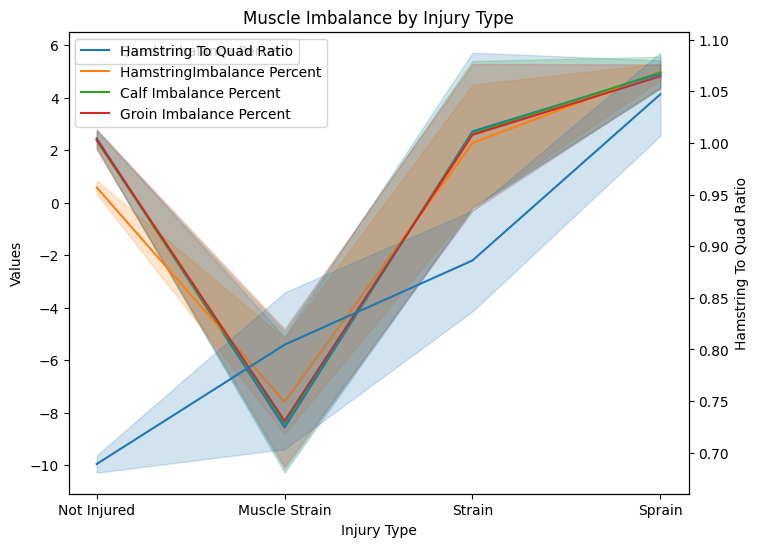

In [257]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

sns.lineplot(x='Injury Type', y='Quad Imbalance Percent', data=clean_sorted_obt, ax = ax1, label = 'Quad Imbalance Percent')
sns.lineplot(x='Injury Type', y='HamstringImbalance Percent', data=clean_sorted_obt, ax = ax1, label = 'HamstringImbalance Percent')
sns.lineplot(x='Injury Type', y='Calf Imbalance Percent', data=clean_sorted_obt, ax = ax1, label = 'Calf Imbalance Percent')
sns.lineplot(x='Injury Type', y='Groin Imbalance Percent', data=clean_sorted_obt, ax = ax1, label = 'Groin Imbalance Percent')
sns.lineplot(x='Injury Type', y='Hamstring To Quad Ratio', data=clean_sorted_obt, ax = ax2, label = 'Hamstring To Quad Ratio')

ax1.set_xlabel('Injury Type')
ax1.set_ylabel('Values')
ax2.set_ylabel('Hamstring To Quad Ratio')
plt.title('Muscle Imbalance by Injury Type')

plt.legend()

plt.show()

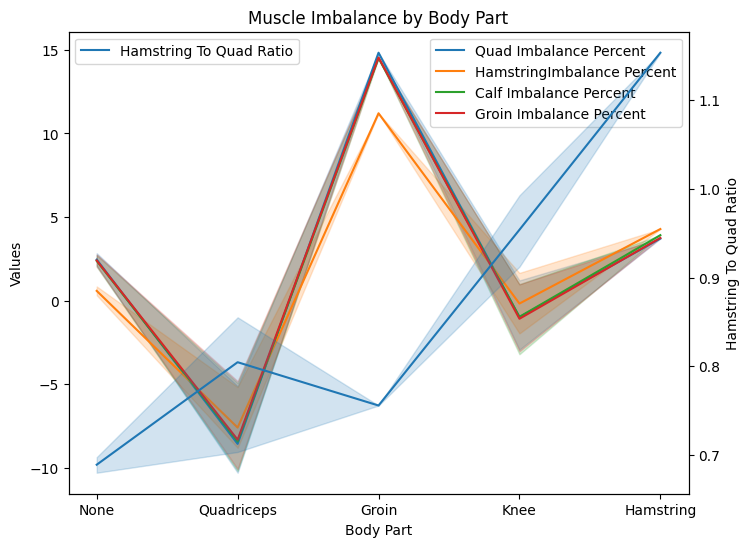

In [255]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

sns.lineplot(x='Body Part', y='Quad Imbalance Percent', data=clean_sorted_obt, ax = ax1, label = 'Quad Imbalance Percent')
sns.lineplot(x='Body Part', y='HamstringImbalance Percent', data=clean_sorted_obt, ax = ax1, label = 'HamstringImbalance Percent')
sns.lineplot(x='Body Part', y='Calf Imbalance Percent', data=clean_sorted_obt, ax = ax1, label = 'Calf Imbalance Percent')
sns.lineplot(x='Body Part', y='Groin Imbalance Percent', data=clean_sorted_obt, ax = ax1, label = 'Groin Imbalance Percent')
sns.lineplot(x='Body Part', y='Hamstring To Quad Ratio', data=clean_sorted_obt, ax = ax2, label = 'Hamstring To Quad Ratio')

ax1.set_xlabel('Body Part')
ax1.set_ylabel('Values')
ax2.set_ylabel('Hamstring To Quad Ratio')
plt.title('Muscle Imbalance by Body Part')

plt.legend()

plt.show()

/tmp/ipykernel_16003/747972315.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


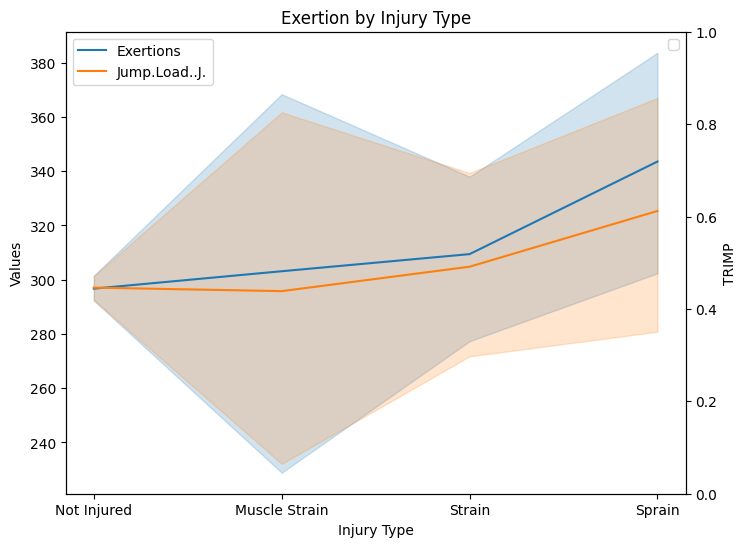

In [263]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

sns.lineplot(x='Injury Type', y='Exertions', data=clean_sorted_obt, ax = ax1, label = 'Exertions')
sns.lineplot(x='Injury Type', y='Jump.Load..J.', data=clean_sorted_obt, ax = ax1, label = 'Jump.Load..J.')

ax1.set_xlabel('Injury Type')
ax1.set_ylabel('Values')
ax2.set_ylabel('TRIMP')
plt.title('Exertion by Injury Type')

plt.legend()

plt.show()

## Encoding and Scaling

In [167]:
non_cat_data = clean_sorted_obt.select_dtypes(include=['number', 'datetime'])
non_cat_data

,index,Player.ID,Date Recorded,Hamstring To Quad Ratio,Calf Imbalance Percent,Groin Imbalance Percent,Month,Year,Session_Date,Distance..mi.,...,Heart.Rate.Recoveries,Jump.Height..max....ft.,Exertions,Disk.Usage....,Injury Date,Recovery Time (days),injury_number,days_before_injury,Injury_history,Injury_status
0,930,101,2023-01-01,0.610768,5.409497,5.616962,1,2023,2023-01-01,5.27,...,10,2.37,132,23.12,2026-12-31,0.0,0.0,1460 days,1,1
1,931,101,2023-01-01,0.610768,5.409497,5.616962,1,2023,2023-01-03,5.79,...,4,3.52,194,74.68,2026-12-31,0.0,0.0,1458 days,1,1
2,932,101,2023-01-01,0.610768,5.409497,5.616962,1,2023,2023-01-04,3.94,...,5,2.41,413,52.18,2026-12-31,0.0,0.0,1457 days,1,1
3,933,101,2023-01-01,0.610768,5.409497,5.616962,1,2023,2023-01-06,3.11,...,8,2.12,359,37.75,2026-12-31,0.0,0.0,1455 days,1,1
4,934,101,2023-01-01,0.610768,5.409497,5.616962,1,2023,2023-01-07,3.79,...,5,2.10,405,62.07,2026-12-31,0.0,0.0,1454 days,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2460,271,115,2023-12-01,1.173804,3.361765,3.485792,12,2023,2023-12-24,3.09,...,7,1.93,296,15.41,2026-12-31,0.0,0.0,1103 days,1,1
2461,272,115,2023-12-01,1.173804,3.361765,3.485792,12,2023,2023-12-25,2.98,...,4,2.00,395,24.67,2026-12-31,0.0,0.0,1102 days,1,1
2462,273,115,2023-12-01,1.173804,3.361765,3.485792,12,2023,2023-12-26,1.99,...,1,2.34,326,48.27,2026-12-31,0.0,0.0,1101 days,1,1
2463,274,115,2023-12-01,1.173804,3.361765,3.485792,12,2023,2023-12-28,3.02,...,6,1.89,444,50.06,2026-12-31,0.0,0.0,1099 days,1,1


In [168]:
clean_sorted_obt = clean_sorted_obt.reset_index()

In [169]:
clean_sorted_obt.columns

Index(['level_0', 'index', 'Player.ID', 'Date Recorded',
       'Hamstring To Quad Ratio', 'Calf Imbalance Percent',
       'Groin Imbalance Percent', 'Month', 'Year', 'Session_Date', 'Position',
       'Distance..mi.', 'Distance...min..mi.', 'Duration..s.', 'Steps',
       'Speed....of.max......', 'Speed..max....mph.', 'Speed..?ò...mph.',
       'Time..s.', 'Accumulated.Acceleration.Load',
       'Anaerobic.Activity..distance...mi.', 'Jump.Load..J.',
       'Heart.Rate..?ò...bpm.', 'Heart.Rate..min....bpm.',
       'Heart.Rate..max....bpm.', 'Human.Core.Temperature..?ò....F.',
       'Human.Core.Temperature..max.....F.', 'TRIMP', 'Heart.Rate.Recoveries',
       'Jump.Height..max....ft.', 'Exertions', 'Disk.Usage....', 'Injury Type',
       'Body Part', 'Side', 'Injury Date', 'Severity', 'Recovery Time (days)',
       'injury_number', 'injury_timeline', 'days_before_injury',
       'Injury_history', 'Injury_status'],
      dtype='object')

In [ ]:
ohe = OneHotEncoder(sparse_output=False, drop = 'first')

non_cat_data = clean_sorted_obt.select_dtypes(include=['number', 'datetime'])
non_cat_data_columns = non_cat_data.columns.tolist()
cat_columns = set(clean_sorted_obt.columns) - set(non_cat_data.columns)
cat_data = clean_sorted_obt[list(cat_columns)]

multi_colinear_columns = ['Quad Imbalance Percent', 
    'HamstringImbalance Percent','Injury Type',
       'Body Part', 'Side', 'Injury Date', 'Severity', 'Recovery Time (days)', 'Player.ID', 'Date Recorded', 'Session_Date', 'Month', 'Year' 
       ]
for col in multi_colinear_columns:
    if col in non_cat_data.columns:
        non_cat_data.drop(columns = col, inplace = True)

ohe_cat_data = ohe.fit_transform(cat_data)

ohe_cat_df = pd.DataFrame(ohe_cat_data, columns=list(ohe.get_feature_names_out()))
ohe_injury_data = pd.concat([non_cat_data, ohe_cat_df], axis = 1)
ohe_cat_columns = list(ohe.get_feature_names_out())

col_to_drop = ['level_0', 'index']
for col in col_to_drop :
    if col in ohe_injury_data.columns:
        ohe_injury_data.drop(columns = col, inplace = True)

ohe_injury_data

,Hamstring To Quad Ratio,Calf Imbalance Percent,Groin Imbalance Percent,Distance..mi.,Distance...min..mi.,Duration..s.,Steps,Speed....of.max......,Speed..max....mph.,Speed..?ò...mph.,...,Position_Forward,Position_Guard,Injury Type_Not Injured,Injury Type_Sprain,Injury Type_Strain,Side_No Injury,Side_Right,Severity_Grade 1,Severity_Grade 2,Severity_Grade 3
0,0.610768,5.409497,5.616962,5.27,0.13,6246,6552,73.10,13.41,5.93,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.610768,5.409497,5.616962,5.79,0.12,3758,6701,56.88,14.78,7.31,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.610768,5.409497,5.616962,3.94,0.11,4895,10088,57.30,17.84,7.43,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.610768,5.409497,5.616962,3.11,0.10,5319,6355,66.00,16.64,8.64,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.610768,5.409497,5.616962,3.79,0.08,4327,5828,95.48,15.90,9.73,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2460,1.173804,3.361765,3.485792,3.09,0.14,4832,5730,72.69,12.70,6.98,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2461,1.173804,3.361765,3.485792,2.98,0.06,5762,5950,89.08,19.82,5.85,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2462,1.173804,3.361765,3.485792,1.99,0.07,6521,5456,78.26,12.02,9.72,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2463,1.173804,3.361765,3.485792,3.02,0.08,4320,7776,82.90,18.98,9.15,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [183]:
non_cat_data.days_before_injury = pd.to_numeric(non_cat_data.days_before_injury)
ohe_injury_data.days_before_injury = pd.to_numeric(ohe_injury_data.days_before_injury)

In [184]:
data_to_scale = non_cat_data.copy()

In [185]:
scaler = StandardScaler(with_std = True, with_mean= True)

columns = ['level_0', 'index', 'Injury_status', 'Severity_Grade 1',
       'Severity_Grade 2', 'Severity_Grade 3', 'Side_No Injury', 'Injury Type_Not Injured', 'Injury Type_Sprain',
       'Injury Type_Strain', 'Body Part_Hamstring', 'Body Part_Knee',
       'Body Part_None', 'Body Part_Quadriceps']

for col in columns:
    if col in data_to_scale.columns:
        data_to_scale.drop(columns = col, inplace = True)
        
unscaled_data = data_to_scale.select_dtypes(include = ['Int64', 'Float64'], exclude = ["datetime"])

columns_to_scale = list(unscaled_data.columns)

scaled_ohe_injury_data = ohe_injury_data.copy()
scaled_ohe_injury_data[columns_to_scale] = scaler.fit_transform(ohe_injury_data[columns_to_scale])

In [186]:
scaled_ohe_injury_data

,Hamstring To Quad Ratio,Calf Imbalance Percent,Groin Imbalance Percent,Distance..mi.,Distance...min..mi.,Duration..s.,Steps,Speed....of.max......,Speed..max....mph.,Speed..?ò...mph.,...,Position_Forward,Position_Guard,Injury Type_Not Injured,Injury Type_Sprain,Injury Type_Strain,Side_No Injury,Side_Right,Severity_Grade 1,Severity_Grade 2,Severity_Grade 3
0,-0.391441,0.343330,0.362208,1.243962,1.085821,0.851841,-1.033717,-0.208076,-0.544690,-1.183300,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-0.391441,0.343330,0.362208,1.614493,0.723489,-1.648744,-0.955161,-1.447217,-0.050556,-0.150164,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.391441,0.343330,0.362208,0.296260,0.361157,-0.505993,0.830528,-1.415131,1.053133,-0.060326,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.391441,0.343330,0.362208,-0.295164,-0.001176,-0.079848,-1.137579,-0.750487,0.620314,0.845539,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.391441,0.343330,0.362208,0.189376,-0.725841,-1.076866,-1.415423,1.501664,0.353409,1.661566,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2460,2.146932,0.111649,0.122505,-0.309415,1.448154,-0.569311,-1.467090,-0.239398,-0.800775,-0.397218,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2461,2.146932,0.111649,0.122505,-0.387797,-1.450506,0.365393,-1.351102,1.012730,1.767284,-1.243192,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2462,2.146932,0.111649,0.122505,-1.093229,-1.088173,1.128232,-1.611548,0.186127,-1.046039,1.654080,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2463,2.146932,0.111649,0.122505,-0.359294,-0.725841,-1.083901,-0.388401,0.540604,1.464311,1.227350,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [187]:
scaled_ohe_injury_data.columns

Index(['Hamstring To Quad Ratio', 'Calf Imbalance Percent',
       'Groin Imbalance Percent', 'Distance..mi.', 'Distance...min..mi.',
       'Duration..s.', 'Steps', 'Speed....of.max......', 'Speed..max....mph.',
       'Speed..?ò...mph.', 'Time..s.', 'Accumulated.Acceleration.Load',
       'Anaerobic.Activity..distance...mi.', 'Jump.Load..J.',
       'Heart.Rate..?ò...bpm.', 'Heart.Rate..min....bpm.',
       'Heart.Rate..max....bpm.', 'Human.Core.Temperature..?ò....F.',
       'Human.Core.Temperature..max.....F.', 'TRIMP', 'Heart.Rate.Recoveries',
       'Jump.Height..max....ft.', 'Exertions', 'Disk.Usage....',
       'injury_number', 'days_before_injury', 'Injury_history',
       'Injury_status', 'Body Part_Hamstring', 'Body Part_Knee',
       'Body Part_None', 'Body Part_Quadriceps', 'Position_Forward',
       'Position_Guard', 'Injury Type_Not Injured', 'Injury Type_Sprain',
       'Injury Type_Strain', 'Side_No Injury', 'Side_Right',
       'Severity_Grade 1', 'Severity_Grade 2', 

In [199]:
smote = SMOTE(random_state=42)
log_reg = LogisticRegression(solver = 'lbfgs')

predictors = scaled_ohe_injury_data.drop(columns = ["Injury_status", 'Severity_Grade 1',
       'Severity_Grade 2', 'Severity_Grade 3', 'Side_No Injury', 'Injury Type_Not Injured', 'Injury Type_Sprain',
       'Injury Type_Strain', 'Body Part_Hamstring', 'Body Part_Knee',
       'Body Part_None', 'Body Part_Quadriceps', 'Position_Forward', 'Position_Guard', 'Side_Right', 'injury_number', 'Injury_history', 'days_before_injury']) # Dropping target variable and multi-colinear features as well
predictors = predictors.select_dtypes(exclude = ['datetime']) # Removing date time as it should not be needed. 
target = scaled_ohe_injury_data['Injury_status']

x_res, y_res = smote.fit_resample(predictors, target)

In [200]:
x_train, x_test, y_train, y_test = train_test_split(x_res, y_res, train_size=0.7, random_state = 999)

In [201]:
x_train.shape

(3329, 24)

In [202]:
y_train

4105    0
1553    1
4599    0
670     1
2216    1
       ..
217     1
2523    0
225     1
481     1
4444    0
Name: Injury_status, Length: 3329, dtype: int64

In [203]:
scores = cross_val_score(log_reg, x_train, y_train, cv = 5, scoring = 'f1')
cv_score = np.mean(scores)
cv_score

np.float64(0.7566028372921345)

In [204]:
log_reg_model = log_reg.fit(x_train, y_train)
prediction = log_reg_model.predict(x_test)

accuracy = accuracy_score(y_test, prediction)
report = classification_report(y_test, prediction)
print(report)

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       734
           1       0.77      0.76      0.77       693

    accuracy                           0.77      1427
   macro avg       0.77      0.77      0.77      1427
weighted avg       0.77      0.77      0.77      1427



In [205]:
accuracy

0.7736510161177295

In [206]:
prediction = log_reg_model.predict_proba(x_test)
prediction[:,0]

array([0.70286123, 0.01809986, 0.39857142, ..., 0.58781191, 0.25982325,
       0.19840128])

In [207]:
# Get the coefficients for each feature
coefficients = log_reg.coef_

# Print the coefficients
print("Coefficients:", coefficients)

Coefficients: [[-1.76486369 -1.48491494  0.96421054  0.08627874 -0.47514455 -0.15750041
   0.09016081  0.26818735  0.03406354 -0.17323989  0.22691326 -0.05967891
   0.01338482  0.04148389  0.28281148  0.00727509  0.03599163  0.06775359
   0.04312118 -0.00756855 -0.17790073  0.33445418 -0.23183909  0.03901298]]


In [ ]:
X_with_const = sm.add_constant(x_train)

sm_model = sm.Logit(y_train, X_with_const)
result = sm_model.fit()

print(result.pvalues)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 60.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Optimization terminated successfully.
         Current function value: 0.456230
         Iterations 7
const                                  3.191144e-82
Hamstring To Quad Ratio               8.801295e-144
Calf Imbalance Percent                 1.499766e-06
Groin Imbalance Percent                7.002999e-06
Distance..mi.                          4.864636e-02
Distance...min..mi.                    1.646376e-20
Duration..s.                           1.710525e-03
Steps                                  1.492431e-01
Speed....of.max......                  2.981180e-07
Speed..max....mph.                     4.543173e-01
Speed..?ò...mph.                       2.538779e-04
Time..s.                               9.518535e-06
Accumulated.Acceleration.Load          2.105953e-01
Anaerobic.Activity..d

In [208]:
columns = x_train.columns.tolist()
coefficients_with_intercept = coefficients[0].tolist()  

coeff_df = pd.DataFrame({
    'Features': columns,
    'Coefficients': coefficients_with_intercept
})

coeff_df.sort_values('Coefficients')


,Features,Coefficients
0,Hamstring To Quad Ratio,-1.764864
1,Calf Imbalance Percent,-1.484915
4,Distance...min..mi.,-0.475145
22,Exertions,-0.231839
20,Heart.Rate.Recoveries,-0.177901
9,Speed..?ò...mph.,-0.173240
5,Duration..s.,-0.157500
11,Accumulated.Acceleration.Load,-0.059679
19,TRIMP,-0.007569
15,Heart.Rate..min....bpm.,0.007275


## Model 2

In [209]:
rfc = RandomForestClassifier(n_estimators = 200, criterion = 'gini')

model2_cv_scores = np.mean(cross_val_score(rfc, x_train, y_train, cv = 3, scoring = 'f1'))
model2_cv_scores

np.float64(0.9943613935742887)

In [210]:
rfc_model = rfc.fit(x_train, y_train)
model2_pred = rfc_model.predict(x_test)

model2_accuracy = accuracy_score(y_test, model2_pred)
model2_accuracy

0.9971969166082691

In [211]:
print(classification_report(y_test, model2_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       734
           1       1.00      1.00      1.00       693

    accuracy                           1.00      1427
   macro avg       1.00      1.00      1.00      1427
weighted avg       1.00      1.00      1.00      1427



In [212]:
rfc_probabilities = rfc_model.predict_proba(x_test)
rfc_probabilities[:, 1].tolist()

[0.885,
 0.97,
 0.015,
 0.04,
 0.005,
 0.98,
 0.225,
 0.985,
 0.085,
 0.06,
 0.03,
 0.0,
 0.895,
 0.975,
 0.975,
 0.96,
 0.2,
 0.045,
 0.085,
 0.005,
 0.055,
 0.955,
 0.005,
 0.025,
 0.955,
 0.005,
 0.03,
 0.98,
 0.99,
 0.98,
 0.98,
 0.02,
 0.97,
 0.005,
 0.765,
 0.02,
 0.98,
 0.01,
 0.975,
 0.97,
 0.005,
 0.955,
 0.985,
 1.0,
 0.98,
 0.97,
 0.04,
 0.955,
 0.015,
 0.83,
 0.945,
 0.99,
 0.945,
 0.08,
 0.0,
 0.99,
 0.985,
 0.955,
 0.925,
 0.985,
 0.03,
 0.025,
 0.925,
 0.97,
 0.99,
 0.995,
 0.03,
 0.96,
 0.065,
 0.98,
 0.77,
 0.915,
 0.005,
 0.01,
 0.99,
 0.11,
 0.905,
 0.125,
 0.955,
 0.07,
 0.045,
 0.97,
 0.005,
 0.765,
 0.935,
 0.945,
 1.0,
 0.91,
 0.97,
 0.985,
 0.005,
 0.01,
 0.97,
 0.985,
 0.825,
 0.99,
 0.985,
 0.985,
 0.985,
 0.97,
 0.965,
 0.995,
 0.185,
 0.065,
 0.065,
 0.98,
 0.175,
 0.025,
 0.865,
 0.98,
 0.97,
 0.0,
 0.0,
 0.065,
 0.045,
 0.0,
 0.0,
 0.005,
 0.99,
 0.105,
 0.995,
 0.065,
 0.925,
 0.01,
 0.97,
 0.045,
 0.155,
 0.71,
 0.02,
 0.905,
 0.96,
 0.03,
 0.045,
 0.91,